### En este trabajo nos enfrentamos a un problema de clasificación. Tenemos un conjunto de datos de prediccion de diabetes, en el que contamos con los records de los pacientes y su condición de diabetes, categorizado como positivo a negativo. El record de los pacientes incluye  age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. Este dataset, basado en el historial medico y en el perfil demografico del paciente, resulta muy conveniente para desarrollar modelos de machine learning que ayuden a pronosticar los pacientes con alto riesgo de tener diabetes, de modo que esto ayude a anticipar un tratamiento médico adecuado.

### Importamos las librerias a utilizar

In [86]:
import joblib
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

import os

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../utils')  # Agrega la ruta a carpeta1

import bootcampviztools as bt


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_predict
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate

from collections import Counter

### Descargamos el dataset

Descargamos el dataset en formato csv del sitio web de Kaggle  
https://www.kaggle.com/code/danishmubashar/diabetes-hypertension-predict-acc-97/input

Hacemos un split del dataset en train y test y los guardamos en diferentes archivos csv:

In [87]:
'''DATA_PATH = os.path.join("..", "data", "diabetes_prediction_dataset.csv")

from sklearn.model_selection import train_test_split

df_diabetes = pd.read_csv(DATA_PATH)
train, test = train_test_split(df_diabetes,test_size=0.2)
train.to_csv('diabetes_train.csv', sep='\t', encoding='utf-8')
test.to_csv('diabetes_test.csv', sep='\t', encoding='utf-8')'''

'DATA_PATH = os.path.join("..", "data", "diabetes_prediction_dataset.csv")\n\nfrom sklearn.model_selection import train_test_split\n\ndf_diabetes = pd.read_csv(DATA_PATH)\ntrain, test = train_test_split(df_diabetes,test_size=0.2)\ntrain.to_csv(\'diabetes_train.csv\', sep=\'\t\', encoding=\'utf-8\')\ntest.to_csv(\'diabetes_test.csv\', sep=\'\t\', encoding=\'utf-8\')'

### Cargamos el dataset de train y lo exploramos

In [88]:
DATA_PATH = '../data/diabetes_train.csv'
train_set = pd.read_csv(DATA_PATH, sep='\t') # Cargamos el dataset de train

In [89]:
train_set.head() # Miramos la cabecera del dataset

,Unnamed: 0,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,55273,Male,43.0,0,0,No Info,26.43,4.8,140,0
1,1104,Male,23.0,0,0,No Info,31.59,5.8,159,0
2,4679,Female,28.0,0,0,never,42.67,4.0,159,0
3,1673,Female,69.0,0,0,former,25.33,6.5,200,1
4,25005,Female,51.0,0,0,never,21.63,4.0,145,0


In [90]:
# Definimos la función para analizar las columnas del dataset: nombres de las columnas, tipos de datos, faltantes, y cardinalidad
def data_report(df):
    '''Esta funcion describe los campos de un dataframe de pandas de forma bastante clara, crack'''
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)

    return concatenado.T

Con ayuda de la funcion analizamos las columnas a partir del data frame generado.  
Vemos la columna Unnamed:0 con cardinalidad maxima.  
Las demas columnas tienen cardinalidad alta y baja, lo que nos permite tipificarlas como numericas o categoricas.

In [91]:
data_report(train_set)

COL_N,Unnamed: 0,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
DATA_TYPE,int64,object,float64,int64,int64,object,float64,float64,int64,int64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,80000,3,102,2,2,6,4097,18,18,2
CARDIN (%),100.0,0.0,0.13,0.0,0.0,0.01,5.12,0.02,0.02,0.0


**Nulos y duplicados**

En principio el data set no tiene nulos en ninguna de las columnas, como vemos en la tabla anterior.

Tampoco tenemos duplicados:

In [92]:
train_set.duplicated().sum()

np.int64(0)

### Definimos target y tipificamos

In [93]:
target = 'diabetes'

**Categoricas**

Vemos que es una variable categórica binaria:

In [94]:
train_set[target].unique()

array([0, 1])

En base al analisis de las columnas las identificamos como categoricas o numericas según su cardinalidad.  
Decidimos catalogar como categoricas a las columnas con cardinalidad menor o igual a 6 (0.01%) y como numéricas a las mayores.

In [95]:
features_cat = ['gender','hypertension','heart_disease','smoking_history']

Observamos los valores unicos de las variables categoricas para confirmar su correcta tipificación.  
Observamos que hay tanto binarias como multiclase:

In [96]:
for col in features_cat:
    print(col)
    print(train_set[col].unique())
    print('\n')
 

gender
['Male' 'Female' 'Other']


hypertension
[0 1]


heart_disease
[0 1]


smoking_history
['No Info' 'never' 'former' 'current' 'not current' 'ever']




**Numericas**

Definimos las variables numéricas, y vemos que hay tanto discretas como continuas.  
Age, HbA1c_level y blood_glucose_level son discretas y bmi es continua, como indica su cardinalidad.

In [97]:
features_num = ['age','bmi','HbA1c_level','blood_glucose_level']

### Mini EDA

**Distribucion de la variable objetivo**  
Como vemos en la siguiente grafica, la variable objetivo está muy desbalanceada:

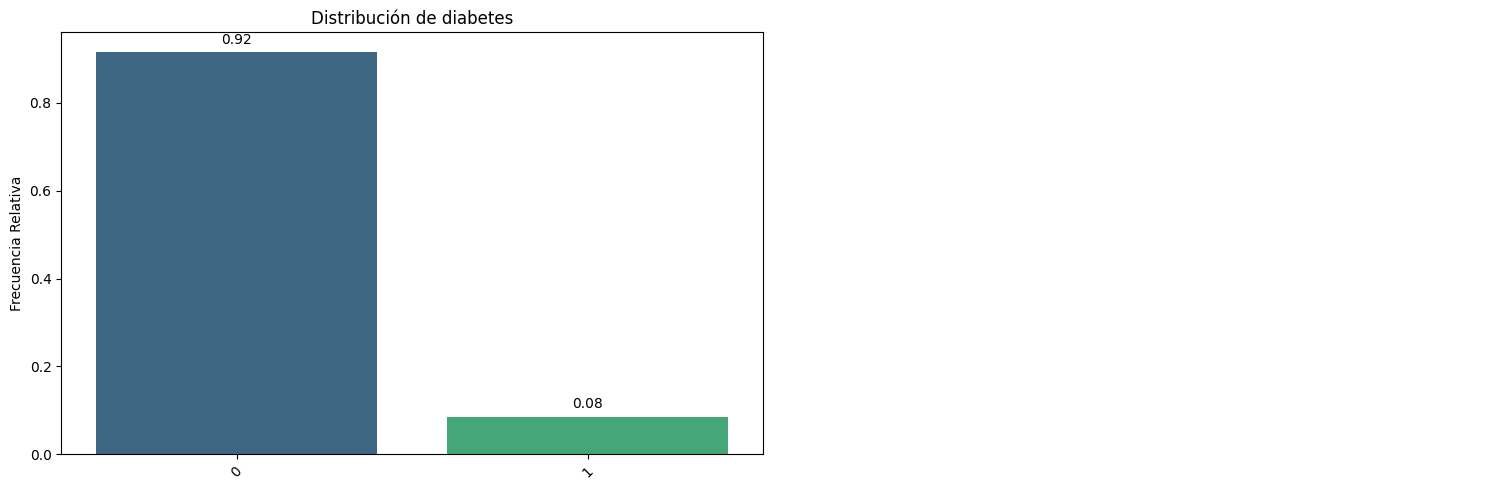

In [98]:
bt.pinta_distribucion_categoricas(train_set, [target], relativa=True, mostrar_valores=True)
#sns.countplot(train_set, x=target, stat="percent") # Otra forma

**Categóricas vs target categorica**

Generamos las graficas usando una funcion de visualizacion del codigo externo bootcampviztools.py  
Nos quedamos con todas las categoricas porque vemos claramente que tener la proporcion diabetes-no_diabetes varía dependiendo la etiqueta de las variables categóricas.

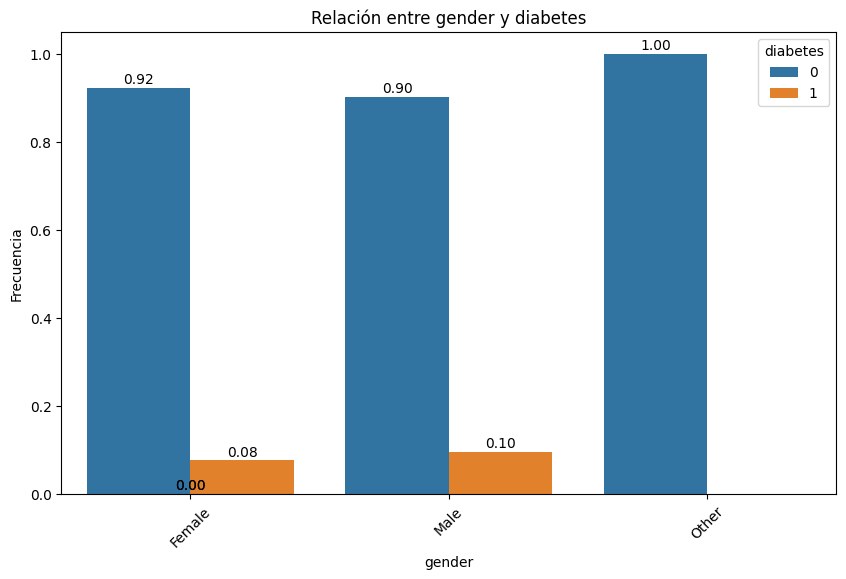

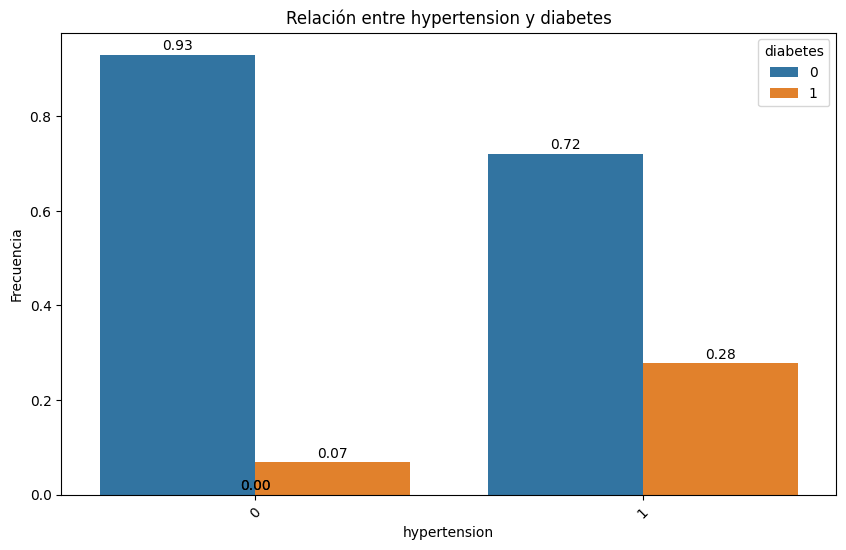

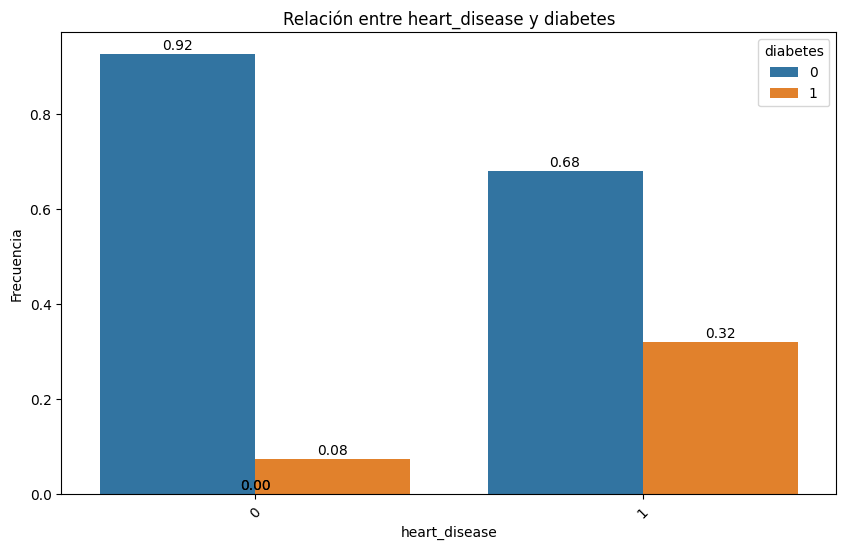

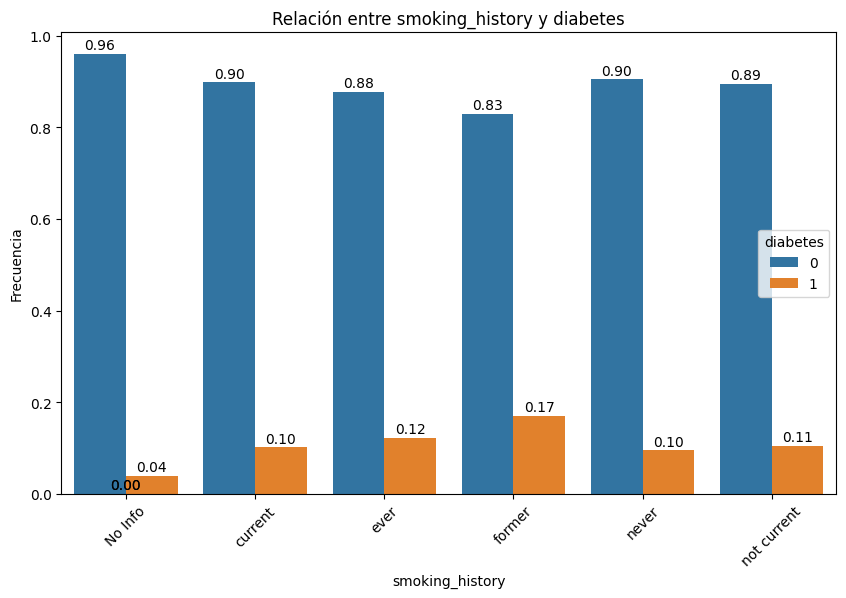

In [99]:
for col_cat in features_cat:
    bt.plot_categorical_relationship_fin(train_set, col_cat, target,relative_freq=True, show_values=True, size_group = 6)

**Numericas vs target categórica**

Hago un análisis bivariante usando un pairplot.  
En las gráficas de la diagonal observamos la distribución de las columnas numéricas en las dos clases de nuestra variable objetivo.  
Nos quedamos con todas las variables numericas porque claramente vemos que en todas se discrimina la variable objetivo.

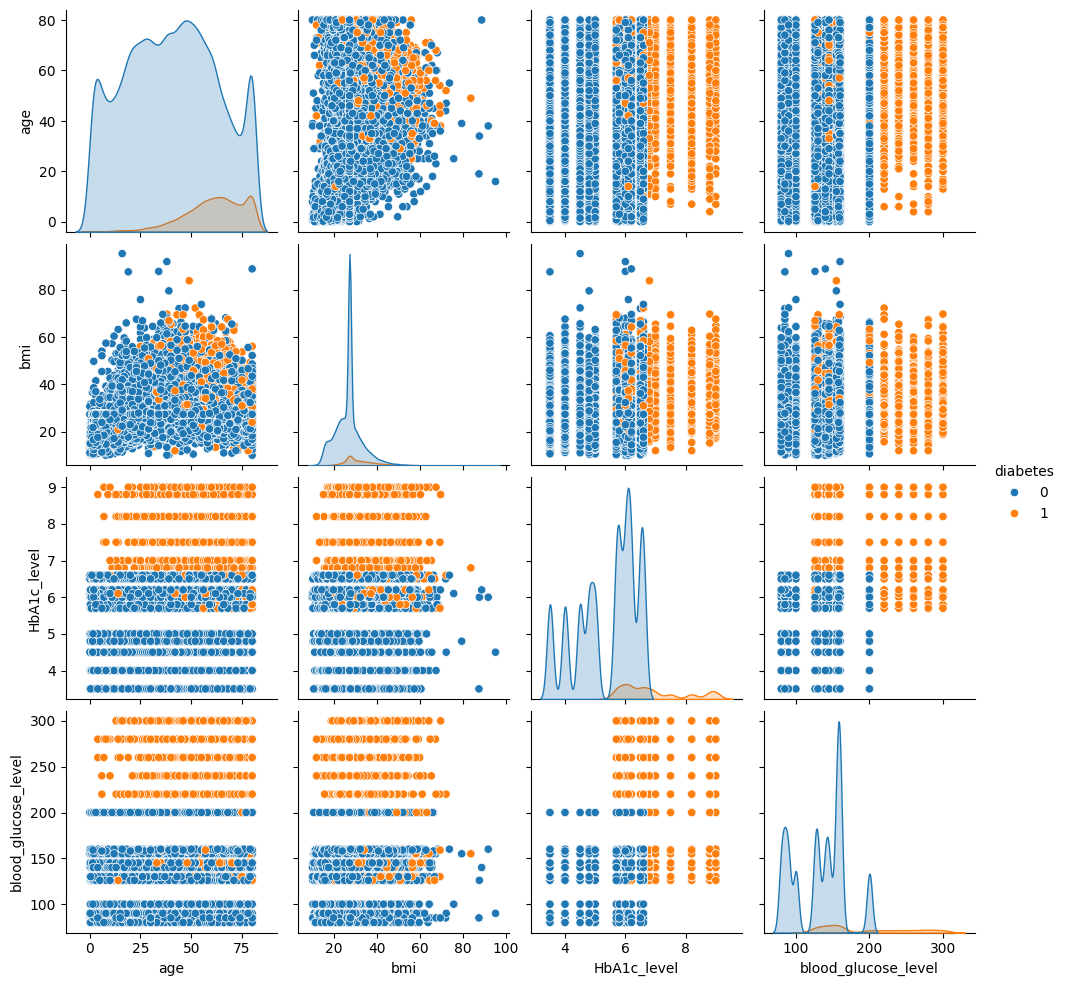

In [100]:
sns.pairplot(train_set.drop(features_cat,axis=1).drop('Unnamed: 0',axis=1), hue = "diabetes");

### Limpieza inicial

Nos apuntamos las columnas que son identificadores unicos para descartarlos posteriormente.

In [101]:
columns_to_exclude = ["Unnamed: 0"]

**gender**

Tener en cuenta que gender es multiclase, y no un variable binaria.  
A parte de Female y Male tiene una etiqueta 'Other' para representar a personas que no se identifican exclusivamente como hombres o mujeres. 

In [102]:
train_set['gender'].value_counts()

gender
Female    46920
Male      33065
Other        15
Name: count, dtype: int64

**smoking_history**

Smoking_history tiene entre sus etiquetas 'No Info' que se refiere a records donde no se ofreció esa información.  
Se debe preparar el codigo para que si recibimos nuevas estancias con nulos en esta columna, podamos imputarlos como 'No Info' 

In [103]:
train_set['smoking_history'].value_counts()

smoking_history
No Info        28650
never          28034
former          7545
current         7398
not current     5184
ever            3189
Name: count, dtype: int64

In [104]:
# Contar los valores únicos de la columna objetivo 'diabetes'
diabetes_counts = train_set['diabetes'].value_counts()
diabetes_counts

diabetes
0    73211
1     6789
Name: count, dtype: int64

### Construyendo Pipelines. Exclusion de columnas

In [105]:
# Separar la variable objetivo y las características
X_train = train_set.drop(columns=[target])
y_train = train_set[target]

# Identificar variables categóricas y numéricas
categorical_features = ["gender", "smoking_history"]
numeric_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level", "hypertension", "heart_disease"]

# Preprocesamiento para variables categóricas (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Preprocesamiento para variables numéricas (escalado estándar)
numeric_transformer = StandardScaler()

# Crear preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Separar en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar preprocesamiento a los datos de entrenamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)
#X_test_preprocessed = preprocessor.transform(X_test)

# Verificar dimensiones después del preprocesamiento
# X_train_preprocessed.shape, X_test_preprocessed.shape
# X_train_preprocessed.shape

In [106]:
# Definir modelos iniciales:
# 1) Regresión Logística
# 2) Random Forest
# 3) XGBoost
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Definir las métricas que queremos evaluar
scoring_metrics = ["accuracy", "precision", "recall", "f1"]

# Evaluar cada modelo con validación cruzada
results = {}

for name, model in models.items():
    scores = cross_validate(model, X_train_preprocessed, y_train, cv=5, scoring=scoring_metrics, n_jobs=-1)
    
    results[name] = {
        "Accuracy": np.mean(scores["test_accuracy"]),
        "Precision": np.mean(scores["test_precision"]),
        "Recall": np.mean(scores["test_recall"]),
        "F1-Score": np.mean(scores["test_f1"])
    }

# Convertir resultados a un DataFrame y mostrar
results_df = pd.DataFrame(results).T
results_df


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.960112,0.865774,0.627337,0.727459
Random Forest,0.969975,0.947965,0.683752,0.794428
XGBoost,0.970637,0.946929,0.692884,0.800195


#### Según el resultado de los modelos en base al Recall vamos a optimizar más adelante XGBoost con GridSearchCV o RandomizedSearchCV para mejorar el Recall aún más.

### Imputamos valores faltantes

### Codificación de Variables Categóricas (OneHotEnconder vs OrdinalEncoder)

### Numericas. Transformación y escalado

In [107]:
# Identificar variables numéricas y categóricas
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

# Definir preprocesadores
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Imputar valores nulos con la mediana
    ("scaler", StandardScaler())  # Escalar características numéricas
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputar valores nulos con el valor más frecuente
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # Convertir variables categóricas en one-hot encoding
])

# Combinar en un ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
    ("Exclude", "drop", columns_to_exclude)
])     

# Aplicar el preprocesamiento a los datos de entrenamiento y prueba
X_train_preprocessed = preprocessor.fit_transform(X_train)
# X_test_preprocessed = preprocessor.transform(X_test)

### Entrenamos modelo XGBoost para encontrar los mejores hiperparámetros

In [108]:
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]  # Ratio entre clases negativas y positivas

# Definir el modelo XGBoost
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    random_state=42, 
    scale_pos_weight=scale_pos_weight  # Ajuste de balanceo real
)

# Definir los hiperparámetros a probar:
    # n_estimators: Número de árboles.
    # max_depth: Profundidad máxima de los árboles.
    # learning_rate: Tasa de aprendizaje.
    # subsample: Fracción de muestras a utilizar para entrenar cada árbol.
    # colsample_bytree: Fracción de características (features) para cada árbol.
param_dist = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=10, cv=3, scoring="recall", 
    n_jobs=-1, random_state=42, verbose=1
)

# Entrenar el modelo
random_search.fit(X_train_preprocessed, y_train)

# Obtener los mejores parámetros y el mejor score (recall)
best_params = random_search.best_params_
best_recall = random_search.best_score_

best_params, best_recall


Fitting 3 folds for each of 10 candidates, totalling 30 fits


({'subsample': 1.0,
  'n_estimators': 50,
  'max_depth': 5,
  'learning_rate': 0.05,
  'colsample_bytree': 1.0},
 np.float64(0.9391662984239212))

### Entrenamos el modelo con GridSearchCV con los mejores hiperparámetros que nos ha dado para comprobar su resultado
#### - Modelado y optimización de hiperparámetros con GridSearchCV

In [109]:
# Definir el modelo XGBoost con los hiperparámetros óptimos
xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42,
    subsample=1.0, n_estimators=100, max_depth=3,
    learning_rate=0.05, colsample_bytree=1.0
)

# Definir un espacio reducido de búsqueda en GridSearchCV
param_grid = {
    "n_estimators": [50],
    "max_depth": [5],
    "learning_rate": [0.05],
    "subsample": [1.0],
    "colsample_bytree": [1.0]
}

# Configurar GridSearchCV con los hiperparámetros optimizados
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=3, scoring="recall",
    n_jobs=-1, verbose=1
)

# Entrenar el modelo con GridSearchCV usando solo X_train
grid_search.fit(X_train_preprocessed, y_train)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Obtener probabilidades de predicción con validación cruzada
y_pred_probs = cross_val_predict(best_model, X_train_preprocessed, y_train, cv=3, method="predict_proba")[:, 1]

# Ajustar el umbral de clasificación a 0.3
threshold = 0.3
y_pred_adjusted = (y_pred_probs >= threshold).astype(int)

# Evaluar métricas sobre el conjunto de entrenamiento
final_results = {
    "Accuracy": accuracy_score(y_train, y_pred_adjusted),
    "Precision": precision_score(y_train, y_pred_adjusted),
    "Recall": recall_score(y_train, y_pred_adjusted),
    "F1-Score": f1_score(y_train, y_pred_adjusted)
}

# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame([final_results])
print(results_df)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
   Accuracy  Precision    Recall  F1-Score
0    0.9718        1.0  0.667698  0.800742


### Procesado con pipelines

In [110]:
'''# Modo Pipeline

cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy = "most_frequent")),
     ("OHEncoder", OneHotEncoder())
    ]
)

num_pipeline = Pipeline(
    [("Impute_Mean", SimpleImputer(strategy = "mean")),
     ("SScaler", StandardScaler())
    ]
)

preprocessing = ColumnTransformer(
    [("Process_Numeric", num_pipeline, ["Age","Fare"]),
     ("Process_Categorical", cat_pipeline, ["Sex","Embarked","Pclass"]),
     ("Exclude", "drop", columns_to_exclude)
    ], remainder = "passthrough")
'''

'# Modo Pipeline\n\ncat_pipeline = Pipeline(\n    [("Impute_Mode", SimpleImputer(strategy = "most_frequent")),\n     ("OHEncoder", OneHotEncoder())\n    ]\n)\n\nnum_pipeline = Pipeline(\n    [("Impute_Mean", SimpleImputer(strategy = "mean")),\n     ("SScaler", StandardScaler())\n    ]\n)\n\npreprocessing = ColumnTransformer(\n    [("Process_Numeric", num_pipeline, ["Age","Fare"]),\n     ("Process_Categorical", cat_pipeline, ["Sex","Embarked","Pclass"]),\n     ("Exclude", "drop", columns_to_exclude)\n    ], remainder = "passthrough")\n'

In [111]:
# Pasos a realizar en un Pipeline:
# 1. Imputación de valores faltantes
# 2. Escalado de datos
# 3. Codificación de variables categóricas
# 4. Entrenamiento del modelo

# Definir preprocesamiento
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, ["age", "bmi", "blood_glucose_level"]),
    ("cat", categorical_transformer, ["gender", "smoking_history"])
])

# Crear Pipeline con preprocesamiento + modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Aplicar validación cruzada correctamente
scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")

print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validation accuracy scores: [0.93975   0.9380625 0.9383125 0.942375  0.9394375]
Mean accuracy: 0.9395875


### Resultados de la Validación Cruzada

| **Fold** | **Accuracy** |
|---------|------------|
| **1**   | 93.97% |
| **2**   | 93.80% |
| **3**   | 93.83% |
| **4**   | 93.23% |
| **5**   | 93.94% |

**Accuracy promedio**: **93.95%**

In [112]:
#df_pipe_train = pd.DataFrame(pipe_train, columns = preprocessing.get_feature_names_out())
#df_pipe_train

In [113]:
#df_pipe_train.head()

### Importante, creamos y_train

In [114]:
# y_train = train_set[target]

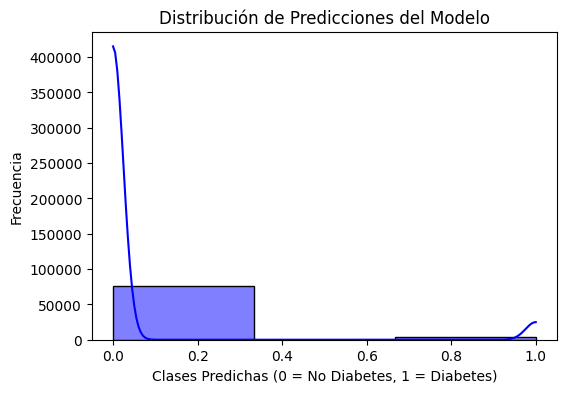

In [115]:
# Visualizar la distribución de predicciones
plt.figure(figsize=(6, 4))
sns.histplot(y_pred_adjusted, bins=3, kde=True, color="blue")
plt.xlabel("Clases Predichas (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Predicciones del Modelo")
plt.show()

### Grabamos el mejor modelo

In [ ]:
# Definir ruta del modelo entrenado y guardado
model_path = "../models/best_model.pkl"

In [ ]:
# Guardar el modelo entrenado
os.makedirs("../models", exist_ok=True)
joblib.dump(model, model_path)
print(f"Modelo guardado en: {model_path}")

Modelo guardado en: src/models/best_model.pkl
